In [1]:
# 만들어진 모델에 대해 loss, accuracy를 그래프로 표현
def display_graph():
    plt.figure(figsize=(16,5))

    # 만들어진 모델에 대해 train dataset과 validation dataset의 loss를 그래프로 표현해 봅니다.
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    # 만들어진 모델에 대해 train dataset과 validation dataset의 accuracy를 그래프로 표현해 봅니다.
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    
    plt.show()

# 예측결과 display 함수(이미지 부문)
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
      color = 'blue'   # 예측결과가 옳으면 blue
    else:
      color = 'red'    # 예측결과가 틀리면 red

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*np.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

# 예측결과 display 함수(그래프 부문)
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')  # 잘못된 예측은 red로 표시
    thisplot[true_label].set_color('blue')      # 올바른 예측은 blue로 표시

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

batch_size = 128   # batch size 정의
num_classes = 10   # 분류하고자 하는 Class가 총 10개
epochs = 100       # training 횟수(epoch)

# input image dimensions
img_rows, img_cols = 28, 28

# 분류할 Class를 정의
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Fashion MNIST dataset을 불러와서 train dataset과 test dataset에 넣어 줍니다.
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


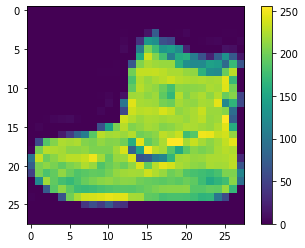

In [3]:
# train dataset의 첫번째 이미지 display
plt.figure()
plt.imshow(x_train[0])
plt.colorbar()
plt.grid(False)
plt.show()

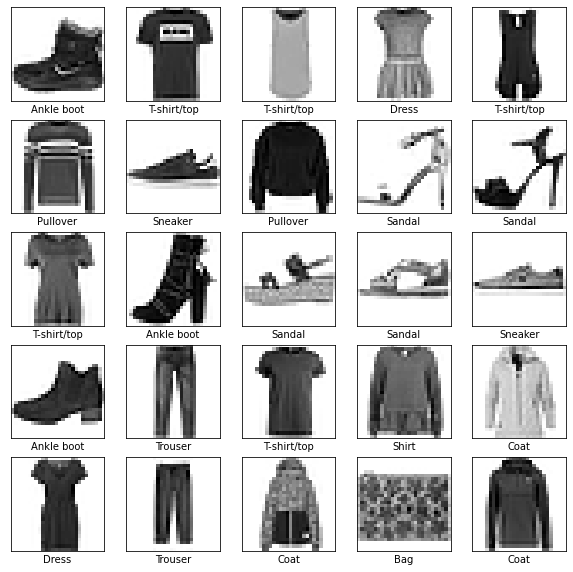

In [4]:
# train dataset의 처음 25개의  이미지를 dispaly
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

In [5]:
# 모델 구성하기
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(img_rows, img_cols, 1)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# 모델 학습과정 설정하기
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# 모델 구성 확인하기
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

In [6]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)  # Reshape
x_train = x_train.astype('float32') / 255  # Feature Scaling(0 ~ 1 사이의 값으로 Data Preprocessing)

x_test_original = x_test  # test data(이미지) 복사
y_test_original = y_test  # test label 복사
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)  # Reshape
x_test = x_test.astype('float32') / 255   # Feature Scaling(0 ~ 1 사이의 값으로 Data Preprocessing)

# label를 One-hot 구조로 변경
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# 모델이 가장 best일때 모델을 저장하도록 설정
modelCheckpoint = ModelCheckpoint('best_fashion_model.h5', save_best_only=True)

# val_acc 를 모니터링 하다가 조기에 학습을 종료하도록 설정
monitor_val_acc = EarlyStopping(monitor='val_accuracy', patience=5)

Epoch 1/100
469/469 [==============================] - 15s 10ms/step - loss: 0.5434 - accuracy: 0.8045 - val_loss: 0.3410 - val_accuracy: 0.8743
Epoch 2/100
469/469 [==============================] - 4s 10ms/step - loss: 0.3526 - accuracy: 0.8745 - val_loss: 0.2924 - val_accuracy: 0.8918
Epoch 3/100
469/469 [==============================] - 5s 11ms/step - loss: 0.3010 - accuracy: 0.8932 - val_loss: 0.2608 - val_accuracy: 0.9079
Epoch 4/100
469/469 [==============================] - 4s 10ms/step - loss: 0.2685 - accuracy: 0.9028 - val_loss: 0.2562 - val_accuracy: 0.9074
Epoch 5/100
469/469 [==============================] - 4s 10ms/step - loss: 0.2448 - accuracy: 0.9110 - val_loss: 0.2366 - val_accuracy: 0.9122
Epoch 6/100
469/469 [==============================] - 4s 10ms/step - loss: 0.2234 - accuracy: 0.9186 - val_loss: 0.2238 - val_accuracy: 0.9191
Epoch 7/100
469/469 [==============================] - 4s 9ms/step - loss: 0.2097 - accuracy: 0.9225 - val_loss: 0.2315 - val_accuracy:

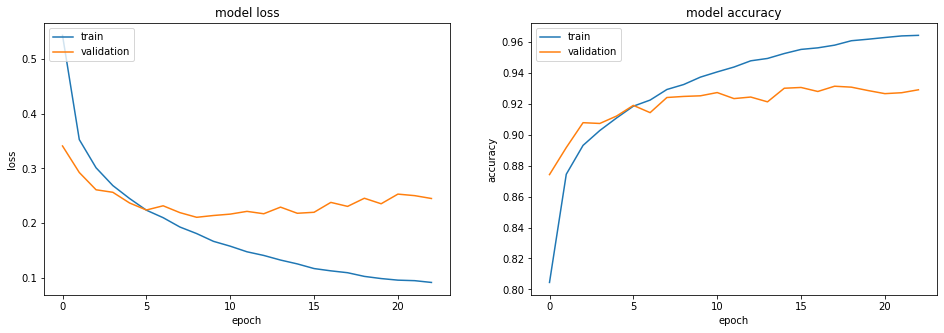

In [7]:
# 모델 학습시키기
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[monitor_val_acc, modelCheckpoint])   # callbacks에 EarlyStopping, ModelCheckpoint 설정

# 모델 평가하기
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

# 그래프 출력
display_graph()

In [8]:
# 예측하기
predictions = model.predict(x_test)

313/313 [==============================] - 1s 2ms/step


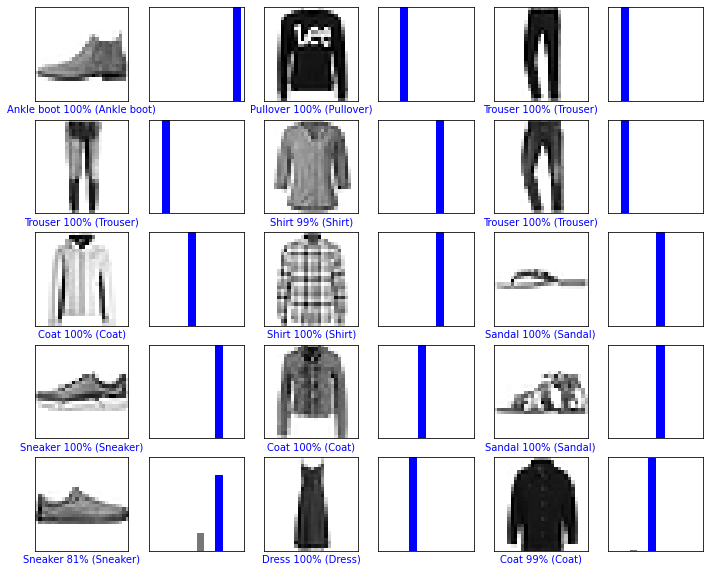

In [9]:
# 예측결과 출력
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)  # 홀수 영역에 display
  plot_image(i, predictions, y_test_original, x_test_original)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)  # 짝수 영역에 display
  plot_value_array(i, predictions, y_test_original)
plt.show()